In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib inline

In [3]:
!pwd

/Users/zzhang/Desktop/version_control/Fusion_analysis


In [6]:
TD_query = '''
        select TD_TIME_FORMAT(order_time,'yyyy-MM-dd') as order_date,
        TD_TIME_FORMAT(td_date_trunc('week',order_time,'America/Los_Angeles'), 'yyyy-MM-dd') as order_week,
        refund_reason_category,
        fusion_eligible as fusion_store_eligible,
        m_transaction_id,
        store_trans_state as order_status,
        dest_country,
        trans_state,
        refund_amount,
        fm_track,
        lm_tracking,
        gmv,
        combined_order_id,
        nvl(after_cb_channel_name,'NULL') as after_cb_channel_name,
        store_state,
        fusion_eligible,
        pre_cancellation,
        nvl(epc_warehouse,'NULL') as epc_warehouse,
        
        order_time,
        order_approved_time,
        marked_shipped,
        confirmed_shipped,
        ts_arrive_epc_warehouse,
        ts_after_cb_parcel_depart_epc_warehouse,
        ts_tpl_delivered,
        ts_wp_delivered,
        ts_arrive_delivery_office,
        delivered,
        picked_up_time,
        refunded_time,
        scanned_time,
        
        case when isnotnull(nvl(order_time,order_approved_time)) then 1 else 0 end as order_by_customer,
        case when isnotnull(nvl(marked_shipped,confirmed_shipped)) then 1 else 0 end as fm_shipped,        
        case when isnotnull(ts_arrive_epc_warehouse) then 1 else 0 end as arrive_epc_warehouse,
        case when isnotnull(ts_after_cb_parcel_depart_epc_warehouse) then 1 else 0 end as after_cb_depart_epc_warehouse,
        CASE WHEN isnotnull(nvl(nvl(ts_wp_delivered,ts_tpl_delivered),delivered)) then 1 else 0 end as lm_delivered_by_carrier,
        CASE WHEN isnotnull(scanned_time) then 1 else 0 end as scanned_by_store,
        CASE WHEN confirmed = 'true'  then 1 ELSE 0 END AS item_confirm_by_store,
        CASE WHEN isnotnull(picked_up_time) THEN 1 ELSE 0 END AS pickedup_by_customer,
        CASE WHEN confirmed = 'true'  AND (scanned_time - order_time)/86400.0<=23 THEN '<=23 days' ELSE '>23 days' END AS SLA_state,
        if(isnotnull(refund_reason_category),1,0) as is_refund,
        if(refund_reason_category IN (20,35,38),1,0) as is_logistics_refund,
        if(refund_reason_category = 41,1,0) as late_fulfillment,
        CASE WHEN isnotnull(fm_track) then 1 else 0 end as has_fm_tracking,
        CASE WHEN isnotnull(lm_tracking) then 1 else 0 end as has_lm_tracking
        --        CASE WHEN fm_track is not null and lm_tracking is not null then 1 else 0 end  as "fm&lm tracking present"

        from analytics.blue_fusion_base_orders a
        LEFT JOIN analytics.blue_fusion_shipment_clean b
        ON a.c_transaction_id = b.transaction_id
           and a.lm_tracking = b.tracking_id
        WHERE trans_state not in (0,4,10)
              and TD_TIME_RANGE(order_time,
                                '2019-07-01', 
                                TD_TIME_ADD(td_date_trunc('day',unix_timestamp(),'America/Los_Angeles'), '-23d'), 
                                'America/Los_Angeles')
        '''

# Step-1: load data

In [49]:
path = "/Users/zzhang/Desktop"
dataset = os.path.join(path , "fusion_raw.csv")

fusion_raw = pd.read_csv(dataset,parse_dates=['order_week','order_date'])

fusion_raw['order_month'] = fusion_raw.order_week.dt.month

fusion_raw.head(5)

,order_date,order_week,refund_reason_category,fusion_store_eligible,m_transaction_id,order_status,dest_country,trans_state,refund_amount,fm_track,...,scanned_by_store,item_confirm_by_store,pickedup_by_customer,sla_state,is_refund,is_logistics_refund,late_fulfillment,has_fm_tracking,has_lm_tracking,order_month
0,2019-07-01,2019-07-01,41.0,True,5d19af8e5ca1aa2ce639c953,20,US,5,3.61,WI000322903822EPC,...,0,0,0,>23 days,1,0,1,1,0,7
1,2019-07-01,2019-07-01,41.0,True,5d19af8f5ca1aa2ce639c954,20,US,5,3.61,WI000322903822EPC,...,0,0,0,>23 days,1,0,1,1,0,7
2,2019-07-01,2019-07-01,NaN,True,5d19af8f5ca1aa2ce639c956,10,US,3,NaN,WI000321260565EPC,...,1,1,1,>23 days,0,0,0,1,1,7
3,2019-07-01,2019-07-01,NaN,True,5d19af905ca1aa2ce639c95c,10,US,3,NaN,WI000320656920EPC,...,1,1,1,>23 days,0,0,0,1,1,7
4,2019-07-01,2019-07-01,NaN,True,5d19af8f5ca1aa2ce639c958,10,US,3,NaN,WI000325001932EPC,...,1,1,1,>23 days,0,0,0,1,1,7


In [50]:
fusion_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146248 entries, 0 to 1146247
Data columns (total 46 columns):
order_date                                 1146248 non-null datetime64[ns]
order_week                                 1146248 non-null datetime64[ns]
refund_reason_category                     277649 non-null float64
fusion_store_eligible                      1146248 non-null bool
m_transaction_id                           1146248 non-null object
order_status                               1146248 non-null int64
dest_country                               1146248 non-null object
trans_state                                1146248 non-null int64
refund_amount                              277649 non-null float64
fm_track                                   1113128 non-null object
lm_tracking                                1032287 non-null object
gmv                                        1146248 non-null float64
combined_order_id                          1136446 non-null object
aft

------------------------------------------------------------------------------------------------------------------------

# Step-2: Funnel analysis

In [51]:
country_month_group = fusion_raw.groupby(['dest_country','order_month'])

In [52]:
funnel = pd.DataFrame(country_month_group.agg({'m_transaction_id': 'nunique',
                   'order_by_customer':'sum',
                   'pre_cancellation':'sum',    
                   'fm_shipped':'sum',
                   'arrive_epc_warehouse':'sum',
                   'after_cb_depart_epc_warehouse':'sum',
                   'lm_delivered_by_carrier':'sum',
                   'scanned_by_store':'sum',
                   'item_confirm_by_store':'sum',
                   'pickedup_by_customer':'sum',
                   'is_refund':'sum',
                   'is_logistics_refund':'sum',
                   'has_fm_tracking':'sum',
                   'has_lm_tracking':'sum',
                   'gmv':'sum',
                   'late_fulfillment':'sum',
                   'refund_amount':'sum'                            
                  })
            )
funnel.reset_index(inplace=True)

In [53]:
funnel.columns

Index(['dest_country', 'order_month', 'm_transaction_id', 'order_by_customer',
       'pre_cancellation', 'fm_shipped', 'arrive_epc_warehouse',
       'after_cb_depart_epc_warehouse', 'lm_delivered_by_carrier',
       'scanned_by_store', 'item_confirm_by_store', 'pickedup_by_customer',
       'is_refund', 'is_logistics_refund', 'has_fm_tracking',
       'has_lm_tracking', 'gmv', 'late_fulfillment', 'refund_amount'],
      dtype='object')

In [66]:
numerators= ['order_by_customer','pre_cancellation','has_fm_tracking','fm_shipped','arrive_epc_warehouse','late_fulfillment','has_lm_tracking',
                'after_cb_depart_epc_warehouse','lm_delivered_by_carrier','scanned_by_store','item_confirm_by_store','pickedup_by_customer',
                'is_refund','is_logistics_refund']

funnel_ratio = funnel[['dest_country','order_month','m_transaction_id','gmv','refund_amount']]
for x in numerators:
    if x == 'pre_cancellation':
        funnel_ratio[x] = 100-round(funnel[x]/funnel['order_by_customer']*100,2)
    elif x == 'late_fulfillment':
        funnel_ratio[x] = funnel_ratio['arrive_epc_warehouse'] - round(funnel[x]/funnel['order_by_customer']*100,2)
    else:
        funnel_ratio[x] = round(funnel[x]/funnel['order_by_customer']*100,2)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [67]:
funnel_ratio

,dest_country,order_month,m_transaction_id,gmv,refund_amount,order_by_customer,pre_cancellation,has_fm_tracking,fm_shipped,arrive_epc_warehouse,late_fulfillment,has_lm_tracking,after_cb_depart_epc_warehouse,lm_delivered_by_carrier,scanned_by_store,item_confirm_by_store,pickedup_by_customer,is_refund,is_logistics_refund
0,CA,7,898,4.919087e+03,1782.539992,100.0,93.32,92.98,92.98,92.54,90.20,89.53,87.42,78.84,77.06,76.73,60.47,38.75,15.59
1,CA,8,741,3.927033e+03,1759.419997,100.0,97.98,97.57,97.57,96.76,90.82,90.69,88.12,72.47,81.38,81.38,52.36,42.24,20.65
2,CA,9,11646,7.295680e+04,17191.060023,100.0,95.43,95.21,95.21,94.70,88.08,83.99,83.75,55.69,56.24,55.84,23.94,22.63,7.39
3,DE,7,669,3.175223e+03,1258.560001,100.0,98.36,98.21,98.21,98.21,96.27,84.30,84.30,84.30,84.30,82.51,61.88,37.97,20.93
4,DE,8,21089,1.002759e+05,27605.979989,100.0,98.84,98.72,98.72,98.49,93.84,93.66,93.66,88.86,81.53,80.93,69.33,27.21,7.58
5,DE,9,44902,2.518730e+05,48253.800101,100.0,97.86,97.69,97.69,97.11,91.40,89.90,89.90,76.67,74.72,74.39,57.59,18.14,2.56
6,ES,9,837,3.952578e+03,1040.110004,100.0,96.77,96.54,96.54,96.06,86.86,82.92,82.92,54.60,62.49,62.37,44.44,24.85,8.72
7,FR,7,1112,4.712358e+03,2088.460000,100.0,95.77,95.32,95.32,95.23,92.17,90.74,90.74,84.89,83.00,80.22,52.52,44.06,19.51
8,FR,8,32846,1.462903e+05,40978.140022,100.0,98.34,98.26,98.26,97.87,92.89,92.37,92.37,87.56,80.98,80.25,67.37,27.29,8.58
9,FR,9,76971,4.086524e+05,77659.860117,100.0,98.03,97.81,97.81,97.41,91.71,91.36,91.36,72.56,70.79,70.38,53.53,16.26,3.27


In [68]:
dataset = os.path.join(path , "fusion_ratio.csv")

funnel_ratio.to_csv(dataset,index=False,)

# Waterfall graph can be viewed from Tableau: https://tableau.i.wish.com/#/views/Fusion_waterfall/Sheet1?:iid=1

------------------------------------------------------------------------------------------------------------------------
# Step-3: checkpoint time distribution:

In [34]:
fusion_raw.columns

Index(['order_date', 'order_week', 'order_time', 'trans_state',
       'refund_reason_category', 'fusion_store_eligible', 'm_transaction_id',
       'order_status', 'dest_country', 'trans_state.1', 'refund_amount',
       'fm_track', 'lm_tracking', 'gmv', 'combined_order_id',
       'after_cb_channel_name', 'store_state', 'fusion_eligible',
       'pre_cancellation', 'epc_warehouse', 'order_time.1',
       'order_approved_time', 'marked_shipped', 'confirmed_shipped',
       'ts_arrive_epc_warehouse', 'ts_after_cb_parcel_depart_epc_warehouse',
       'ts_tpl_delivered', 'ts_wp_delivered', 'ts_arrive_delivery_office',
       'delivered', 'picked_up_time', 'refunded_time', 'order_by_customer',
       'fm_shipped', 'arrive_epc_warehouse', 'after_cb_depart_epc_warehouse',
       'lm_delivered_by_carrier', 'scanned_by_store', 'item_confirm_by_store',
       'pickedup_by_customer', 'sla_state', 'is_refund', 'is_logistics_refund',
       'has_fm_tracking', 'has_lm_tracking', 'order_month'],
  

In [176]:
fusion_raw['order_ship'] = (fusion_raw.confirmed_shipped - fusion_raw.order_time)/86400
fusion_raw['ship_to_wh'] = (fusion_raw.ts_arrive_epc_warehouse - fusion_raw.confirmed_shipped)/86400
fusion_raw['wh_operation'] = (fusion_raw.ts_after_cb_parcel_depart_epc_warehouse - fusion_raw.ts_arrive_epc_warehouse)/86400
fusion_raw['lm_delivery'] = (fusion_raw.ts_wp_delivered - fusion_raw.ts_after_cb_parcel_depart_epc_warehouse)/86400
fusion_raw['scan_time'] = (fusion_raw.scanned_time - fusion_raw.ts_wp_delivered)/86400
fusion_raw['pickup_time'] = (fusion_raw.picked_up_time - fusion_raw.scanned_time)/86400
fusion_raw['first mile'] = (fusion_raw.ts_after_cb_parcel_depart_epc_warehouse - fusion_raw.order_time)/86400
fusion_raw['TTD'] = (fusion_raw.scanned_time - fusion_raw.order_time)/86400

In [177]:
fusion_raw.head()

,order_date,order_week,refund_reason_category,fusion_store_eligible,m_transaction_id,order_status,dest_country,trans_state,refund_amount,fm_track,...,has_lm_tracking,order_month,order_ship,ship_to_wh,wh_operation,lm_delivery,scan_time,pickup_time,first mile,TTD
0,2019-07-01,2019-07-01,41.0,True,5d19af8e5ca1aa2ce639c953,20,US,5,3.61,WI000322903822EPC,...,0,7,0.967789,7.258576,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-07-01,2019-07-01,41.0,True,5d19af8f5ca1aa2ce639c954,20,US,5,3.61,WI000322903822EPC,...,0,7,0.967789,7.258565,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-07-01,2019-07-01,NaN,True,5d19af8f5ca1aa2ce639c956,10,US,3,NaN,WI000321260565EPC,...,1,7,0.843125,4.479803,8.649977,10.4511,0.132812,2.957141,13.972905,24.556817
3,2019-07-01,2019-07-01,NaN,True,5d19af905ca1aa2ce639c95c,10,US,3,NaN,WI000320656920EPC,...,1,7,0.392234,4.928738,8.651921,10.4511,0.132812,2.957141,13.972894,24.556806
4,2019-07-01,2019-07-01,NaN,True,5d19af8f5ca1aa2ce639c958,10,US,3,NaN,WI000325001932EPC,...,1,7,1.906933,5.183079,6.882894,10.4511,0.132812,2.957141,13.972905,24.556817


## Empirical distribution overall

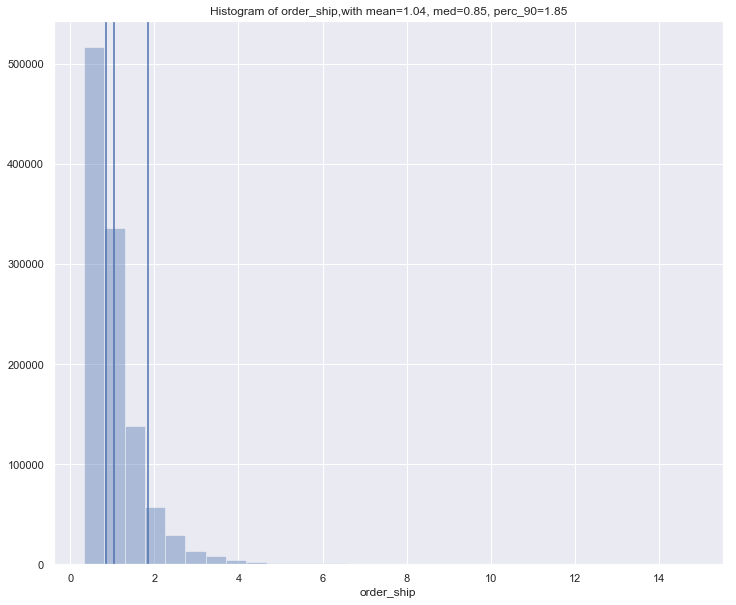

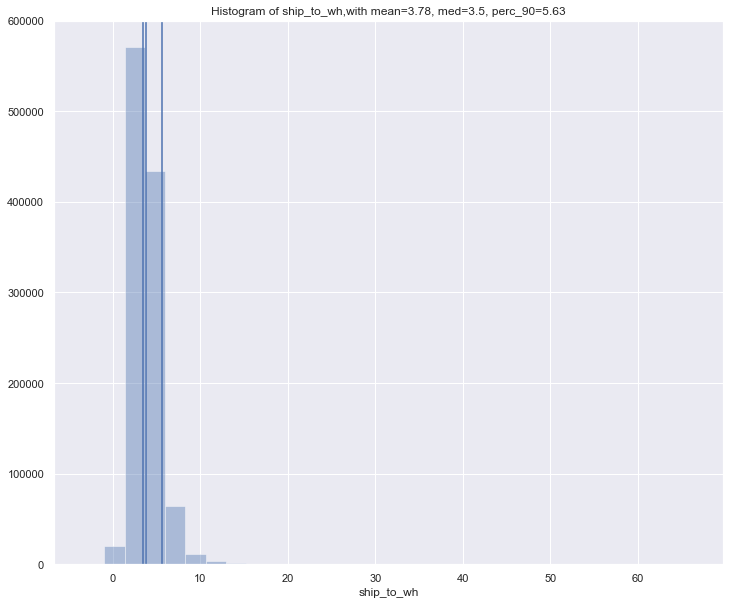

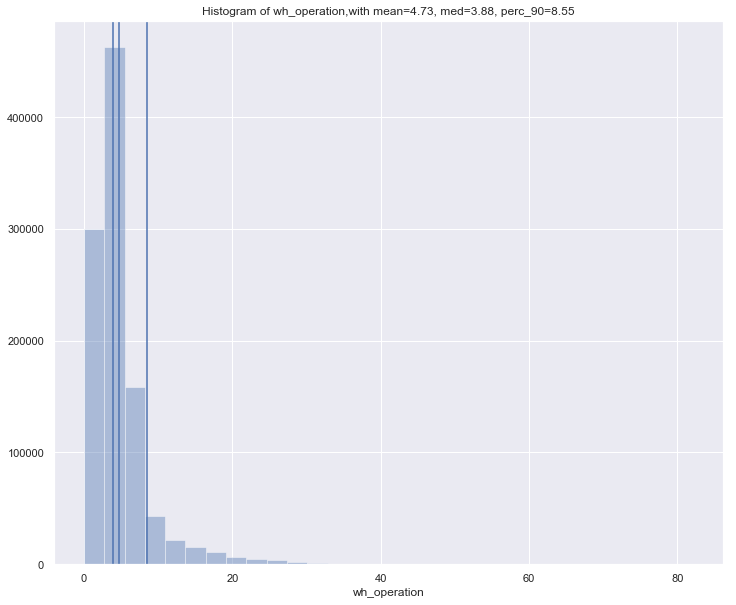

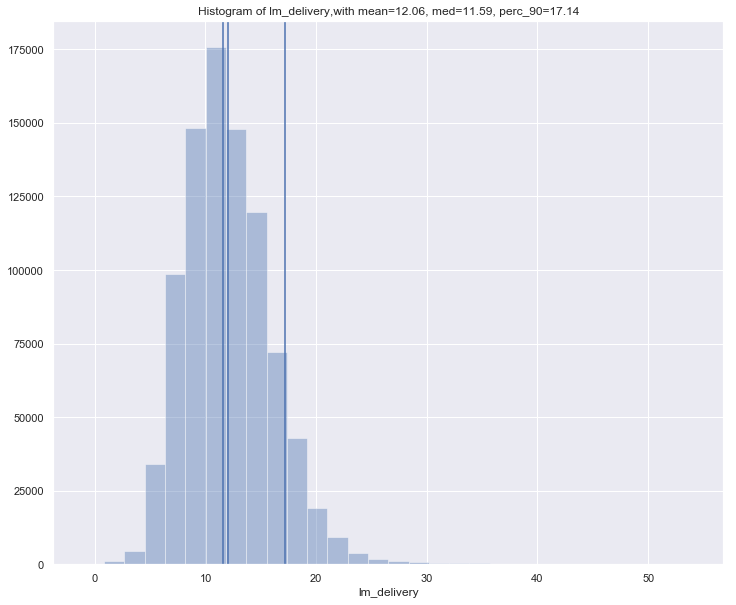

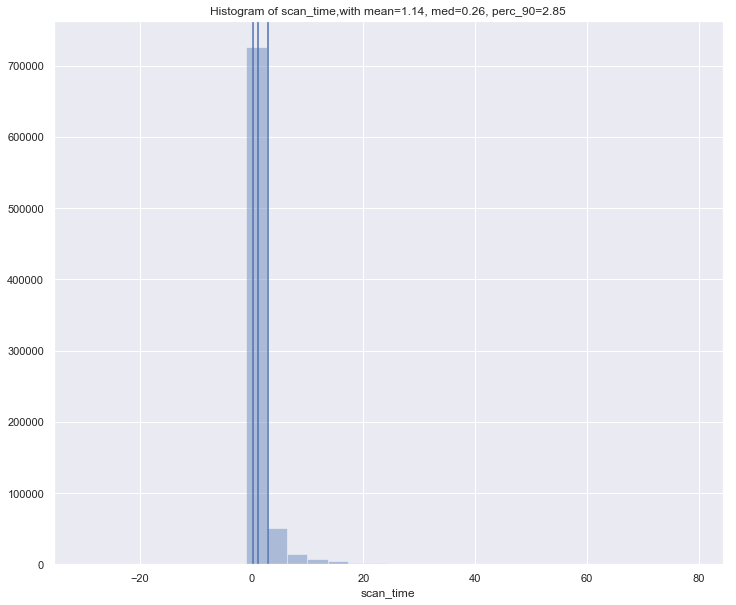

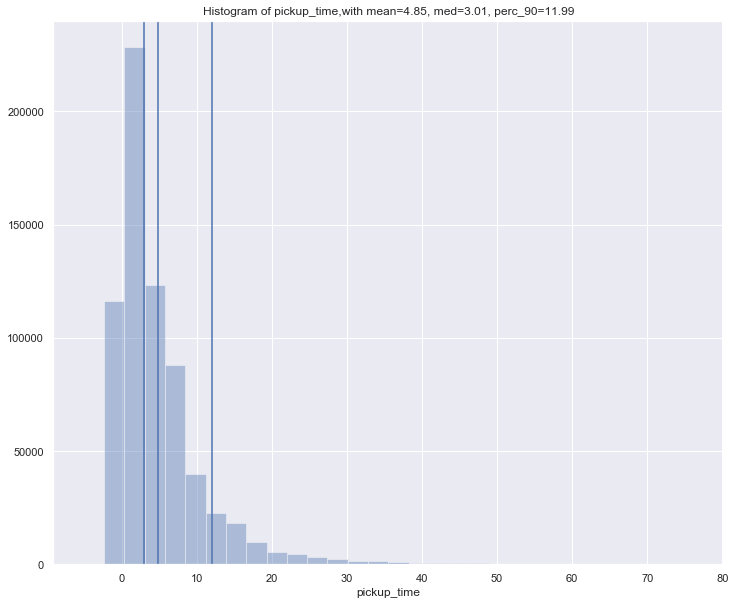

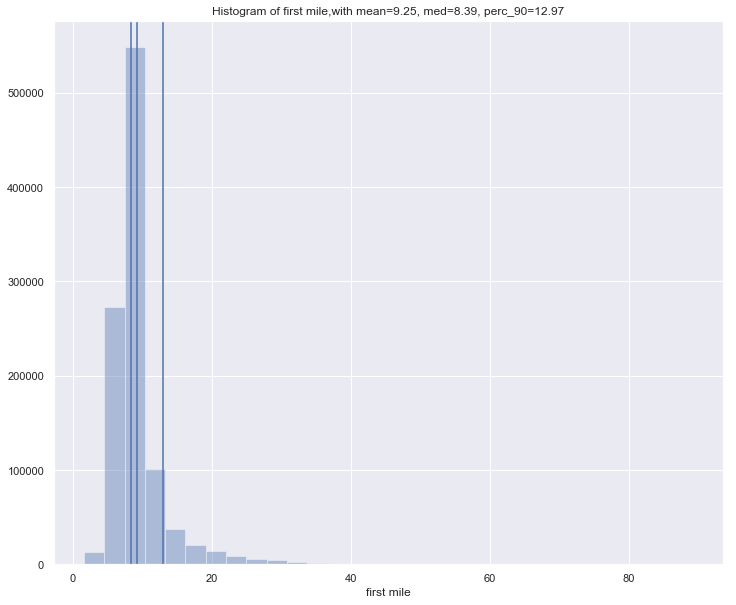

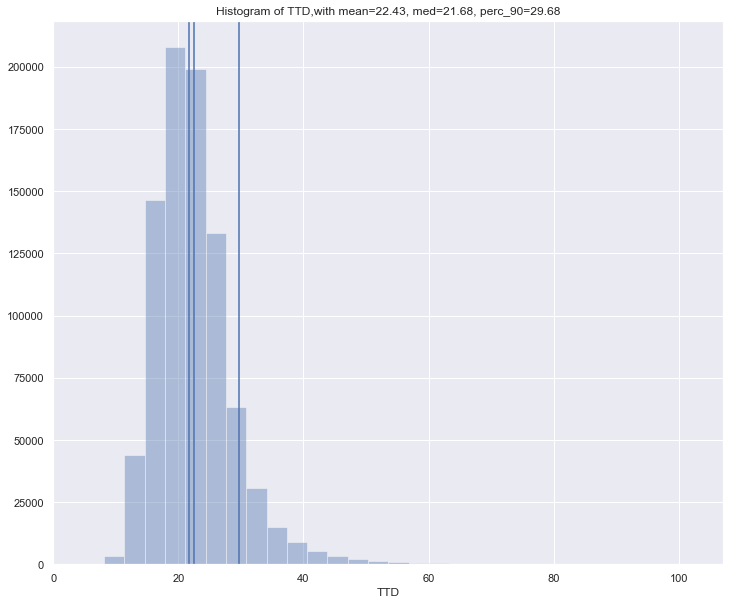

In [179]:
# Density Plot and Histogram of all arrival delays
time_list = ['order_ship','ship_to_wh','wh_operation','lm_delivery','scan_time','pickup_time','first mile','TTD']
for time in time_list:
    avg = (round(fusion_raw.loc[fusion_raw[time].notnull(),time].mean(),2))
    perc_50 = (round(fusion_raw.loc[fusion_raw[time].notnull(),time].median(),2))
    perc_80= round(fusion_raw.loc[fusion_raw[time].notnull(),time].quantile(0.8),2)
    perc_90= round(fusion_raw.loc[fusion_raw[time].notnull(),time].quantile(0.9),2)
    plt.figure()
    sns.set(rc={'figure.figsize':(12,10)})
    sns.distplot(fusion_raw.loc[fusion_raw[time].notnull(),time], hist=True, kde=False, bins=30).\
    set_title('Histogram of %s,with mean=%s, med=%s, perc_90=%s' %(time,avg,perc_50,perc_90))
    plt.axvline(avg, 0, 1)
    plt.axvline(perc_50, 0, 1)
    plt.axvline(perc_90, 0, 1)
    plt.show()

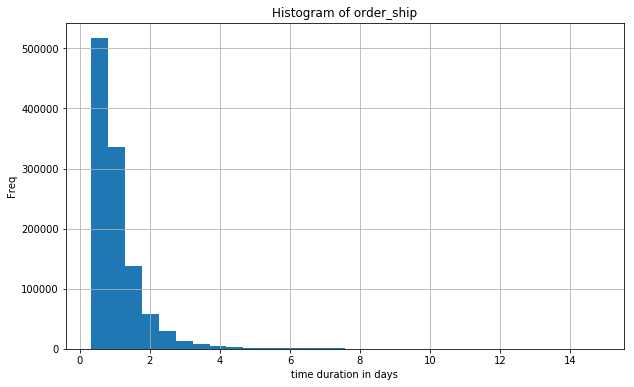

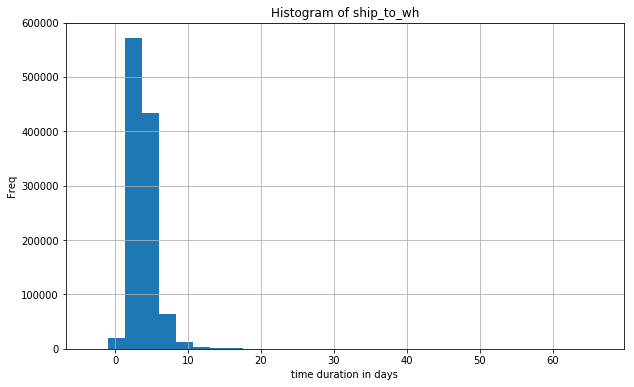

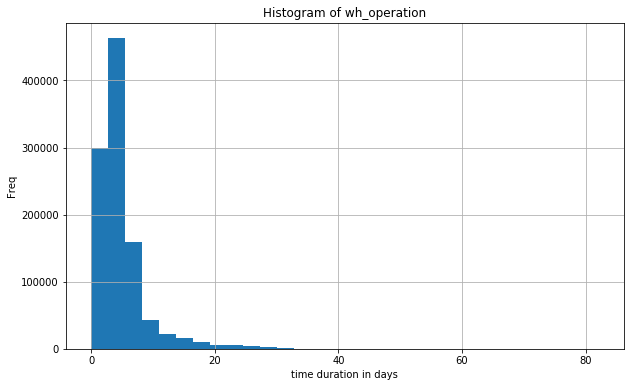

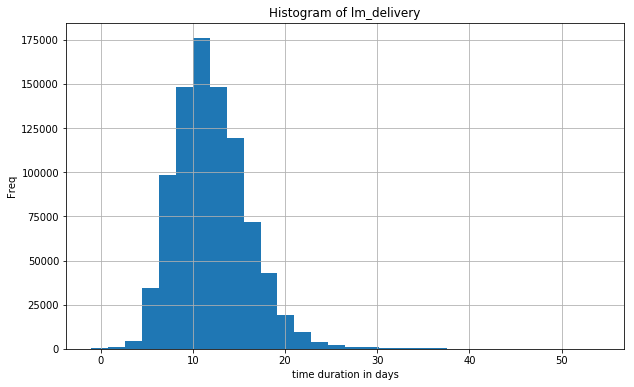

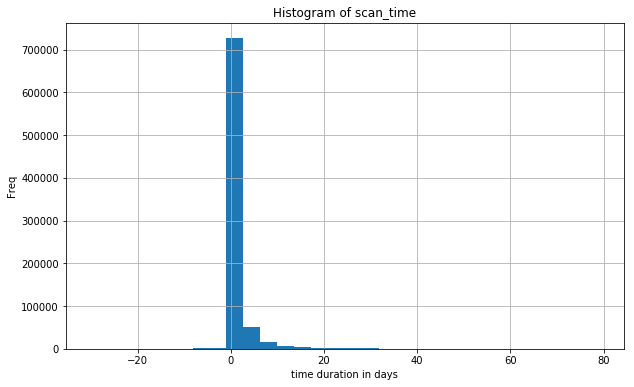

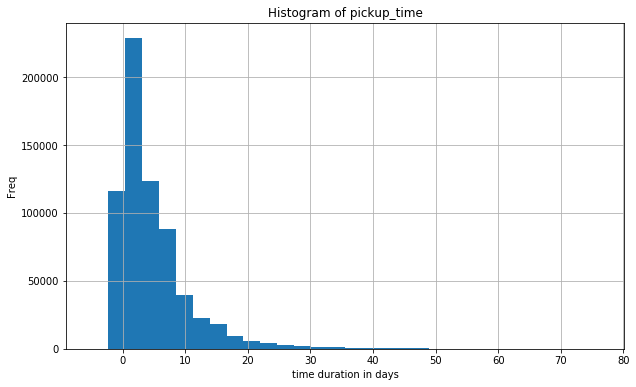

In [133]:
time_list = ['order_ship','ship_to_wh','wh_operation','lm_delivery','scan_time','pickup_time']

for time in time_list:
    plt.xlabel('time duration in days')
    plt.ylabel('Freq')
    plt.title('Histogram of %s' %(time))
#    plt.xlim(xmin=0)
    fusion_raw[time].hist(figsize=(10,6),bins=30)
    plt.show()

## Empirical distribution by dest countries

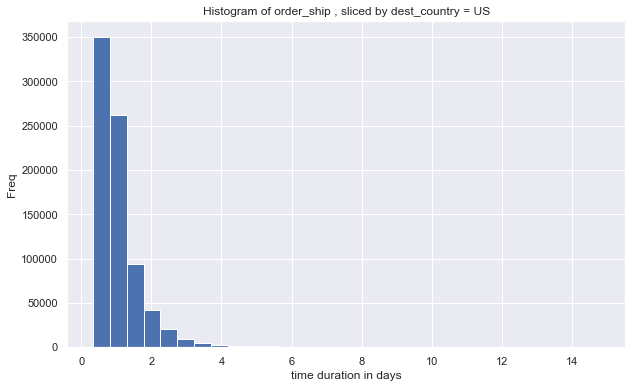

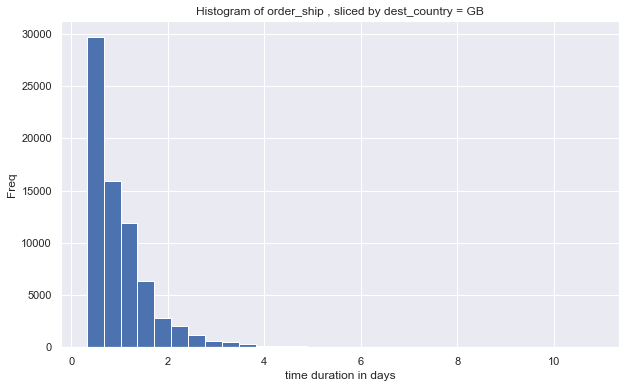

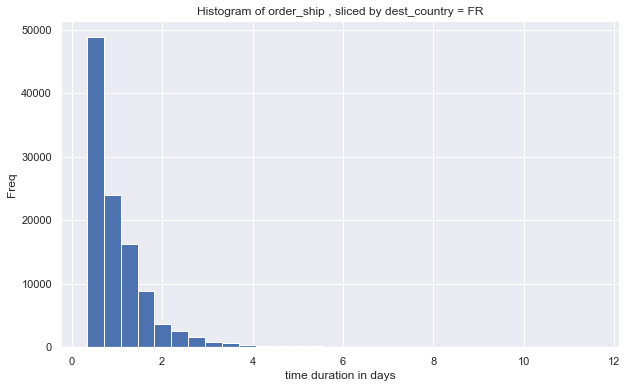

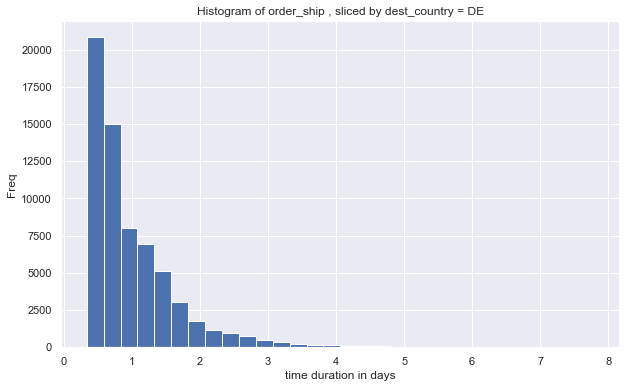

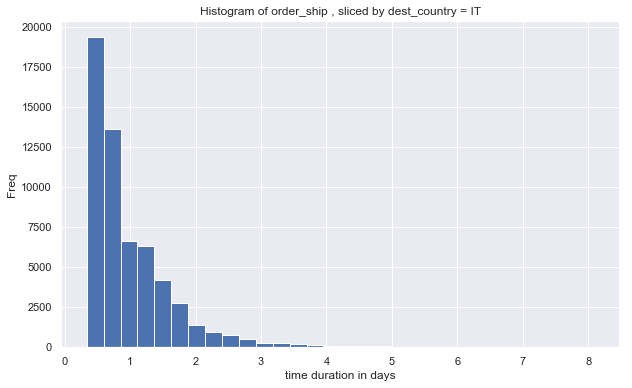

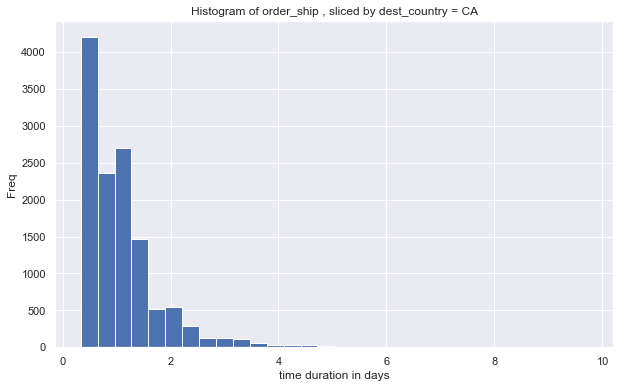

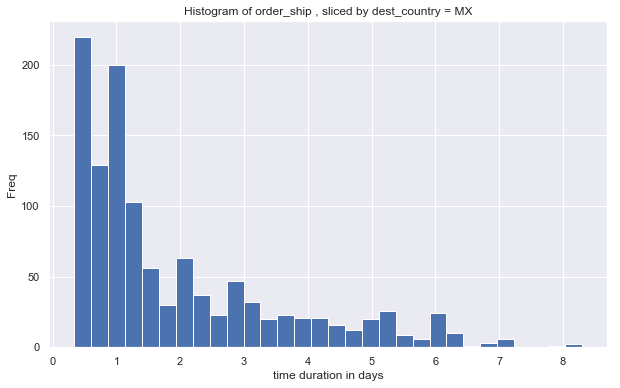

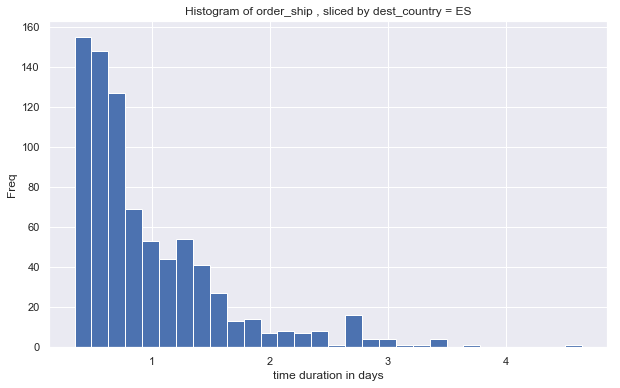

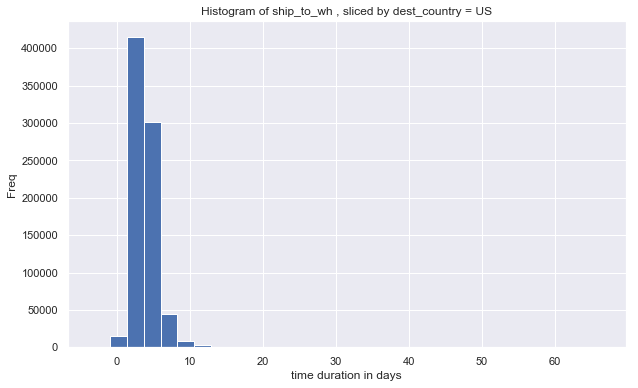

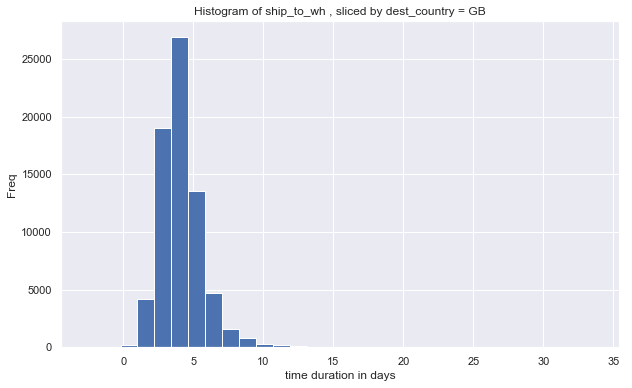

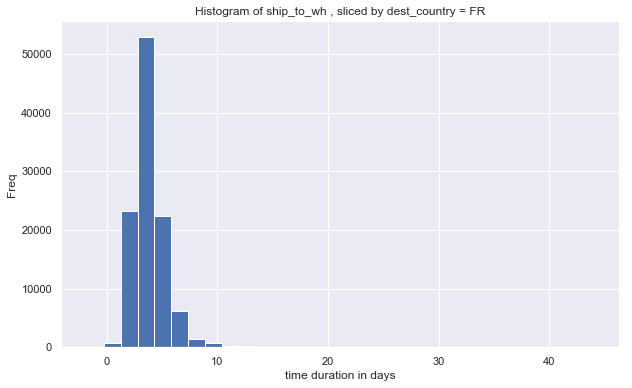

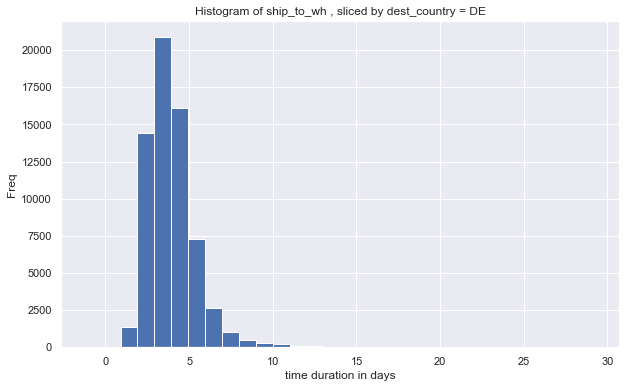

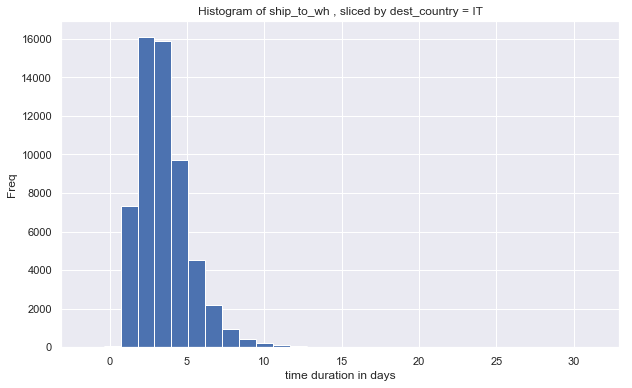

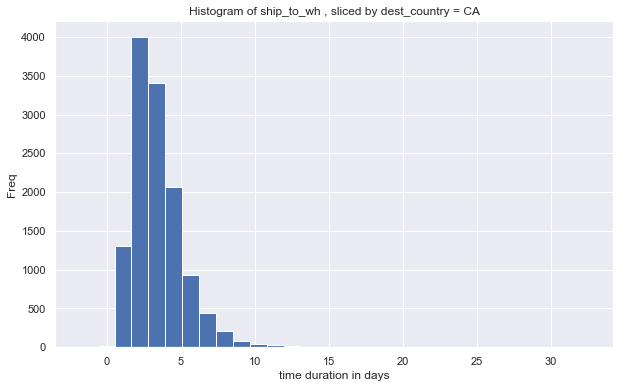

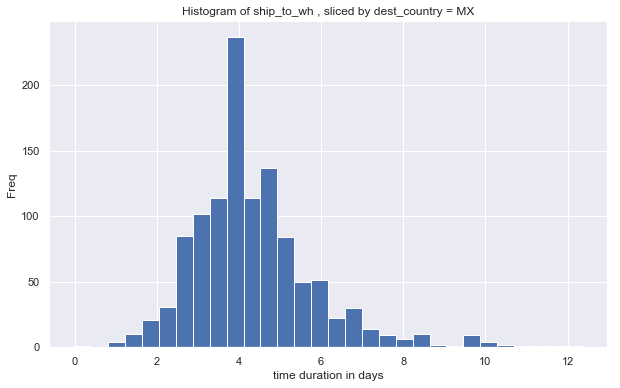

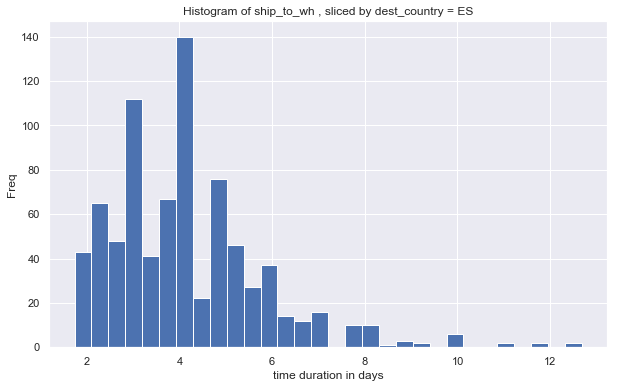

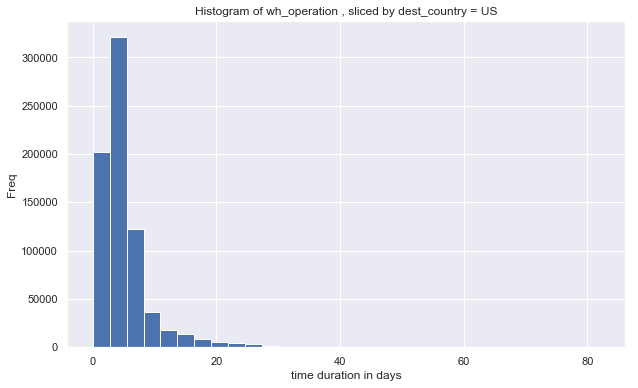

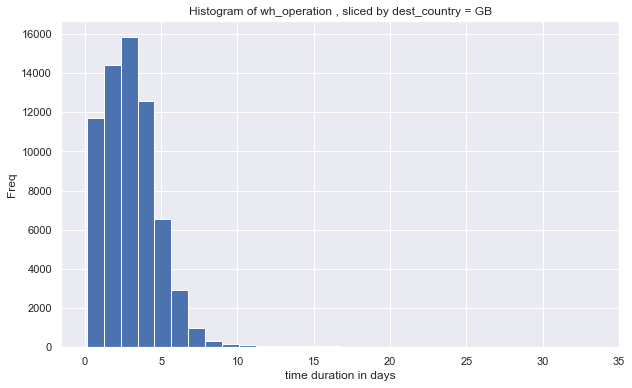

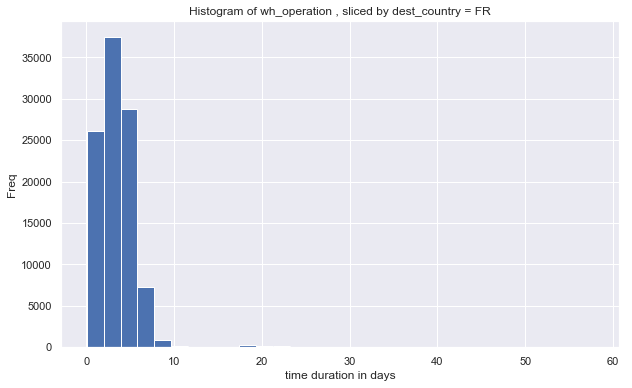

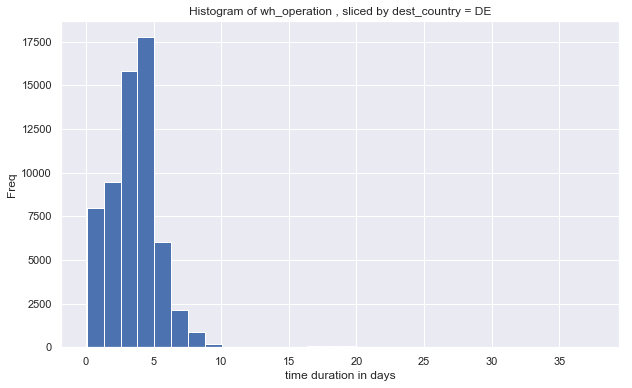

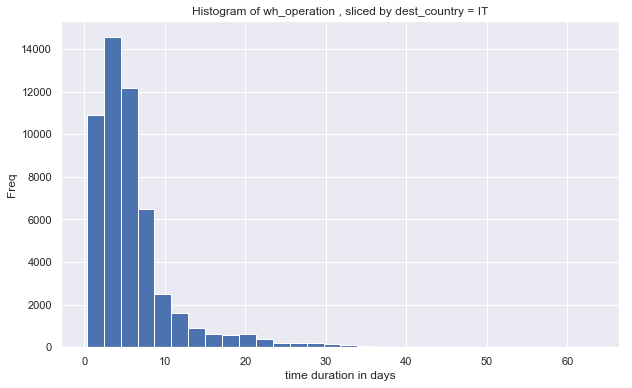

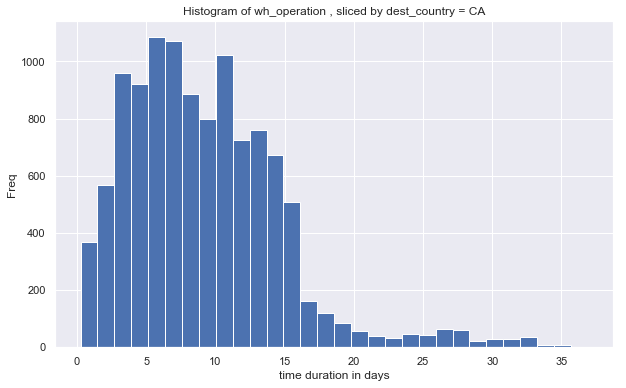

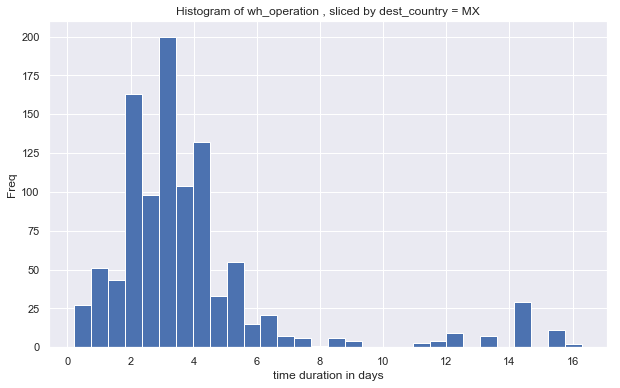

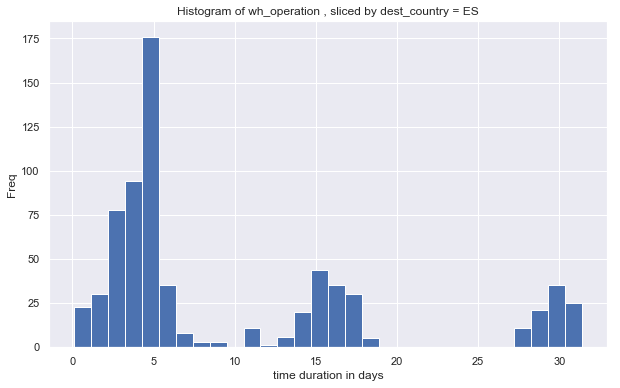

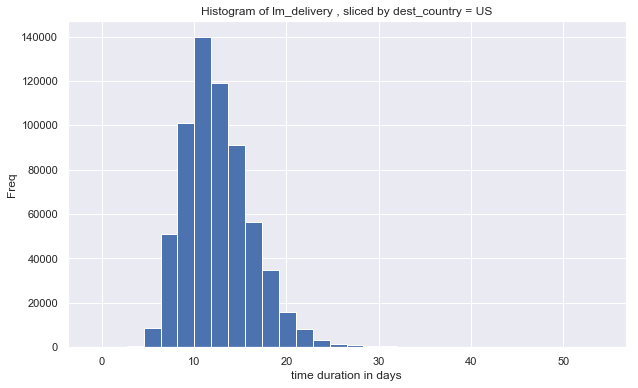

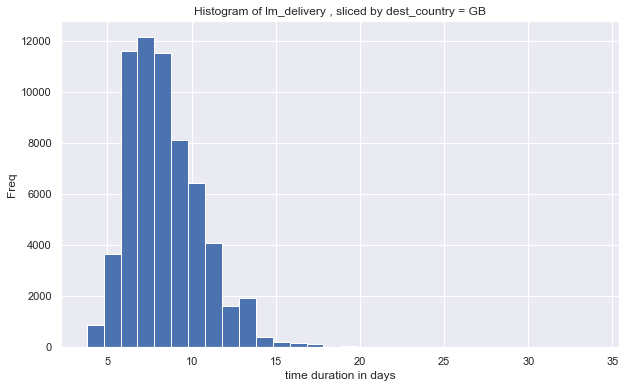

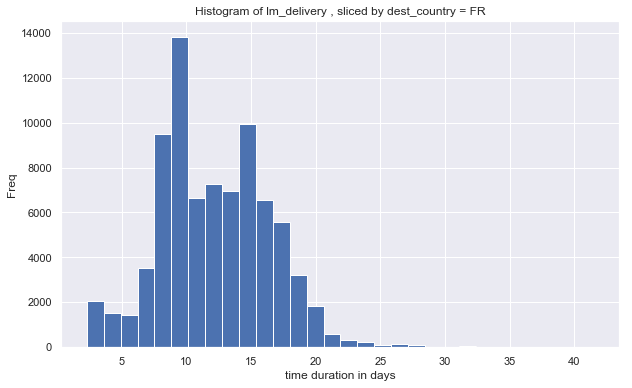

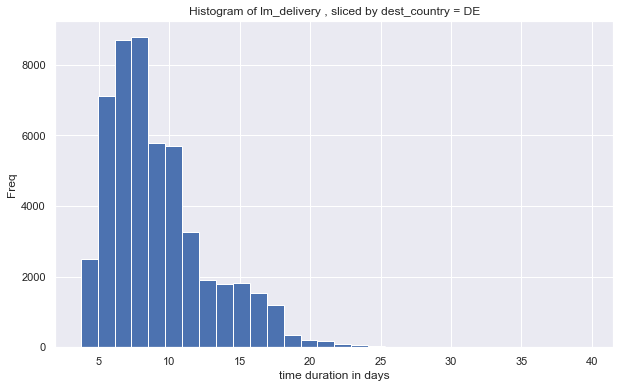

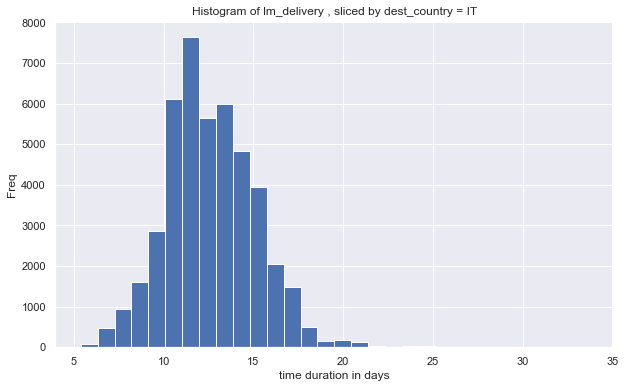

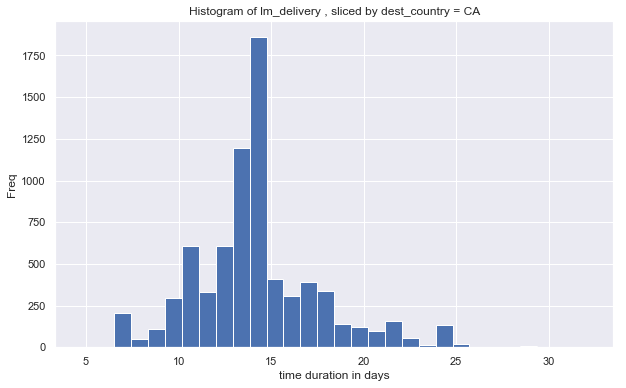

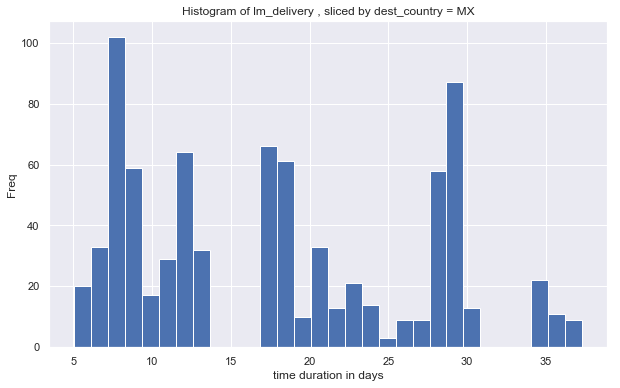

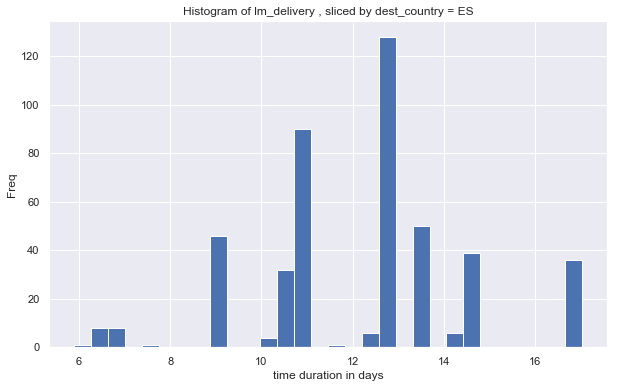

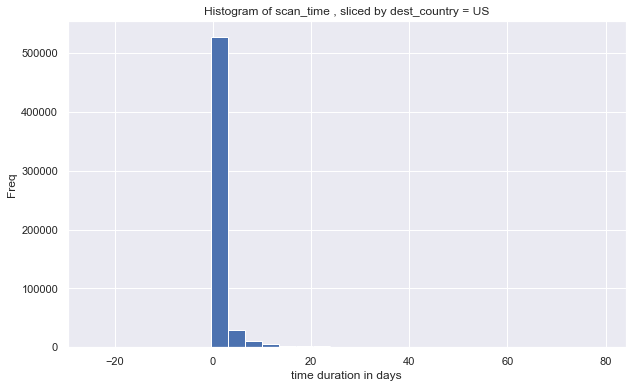

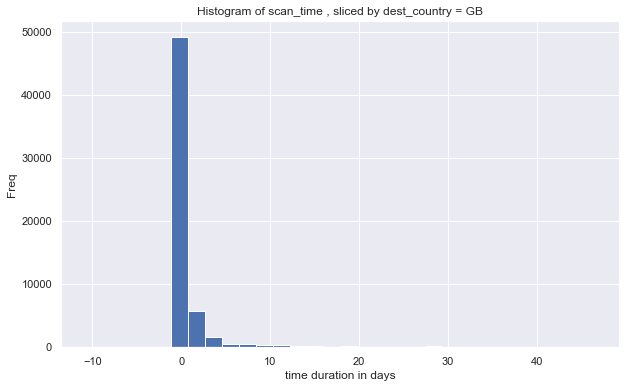

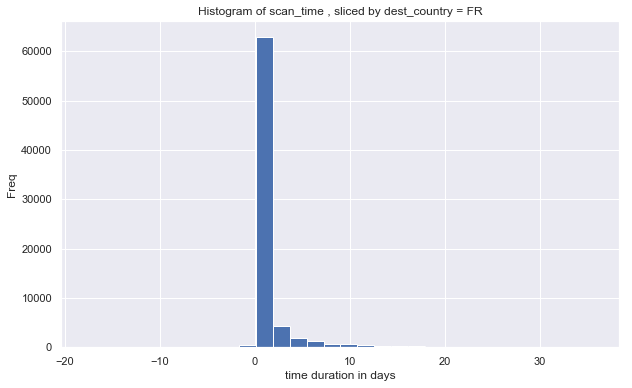

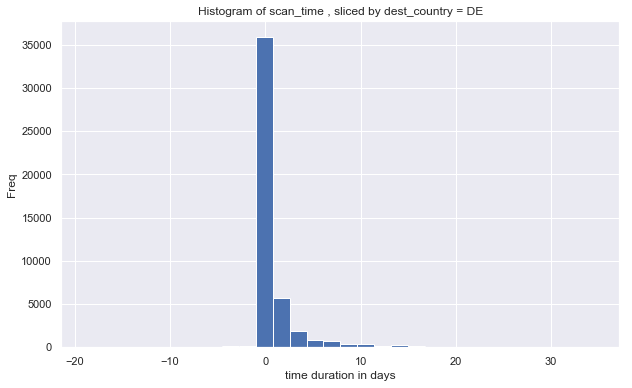

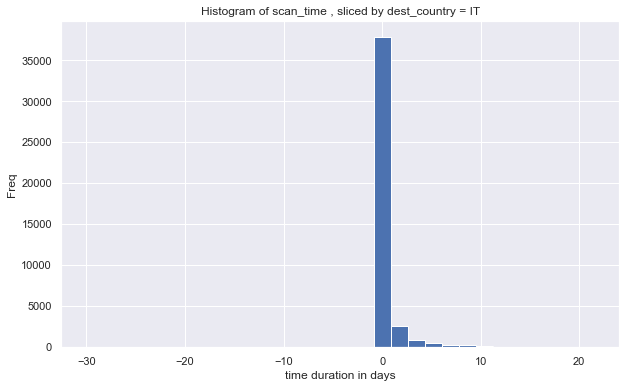

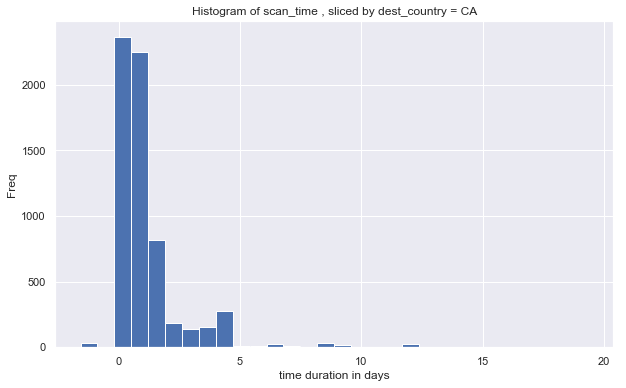

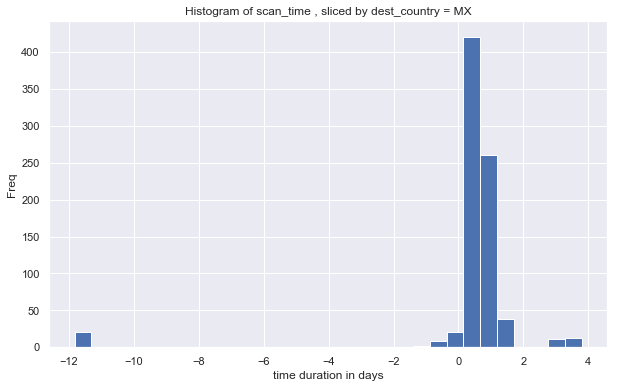

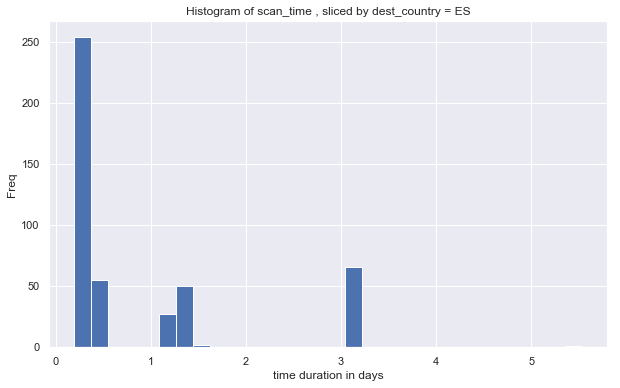

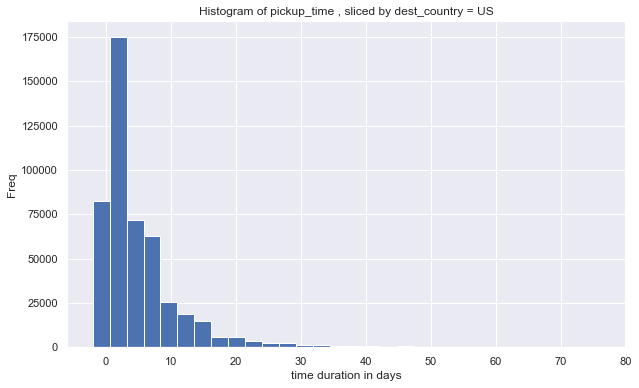

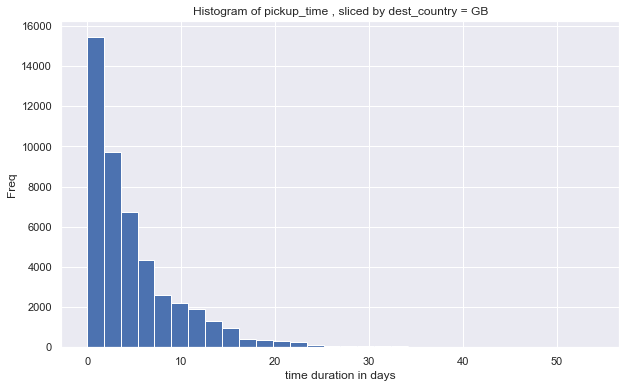

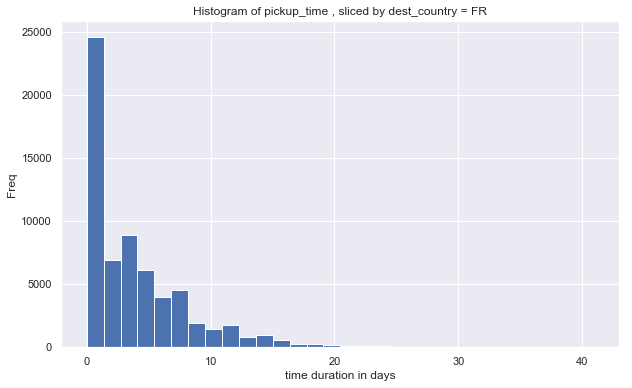

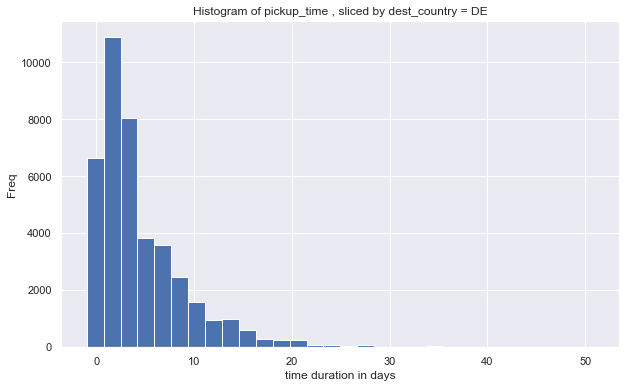

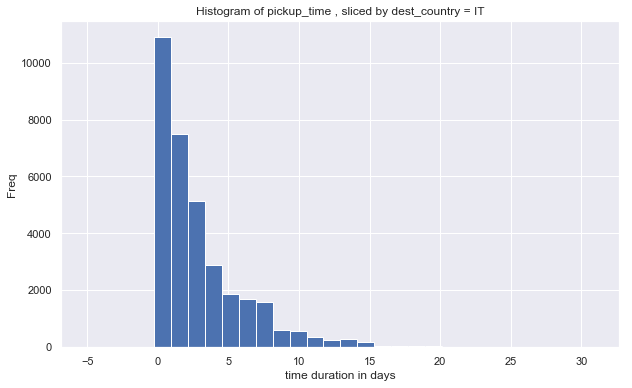

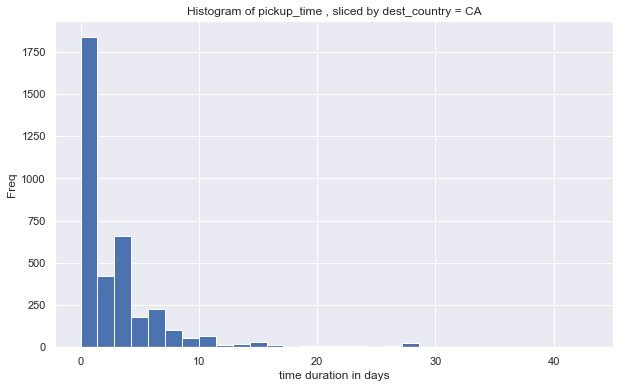

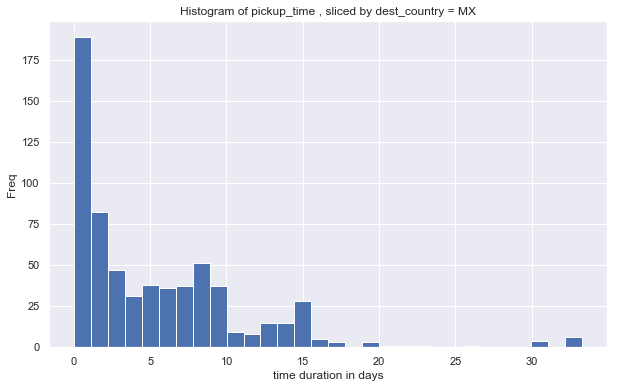

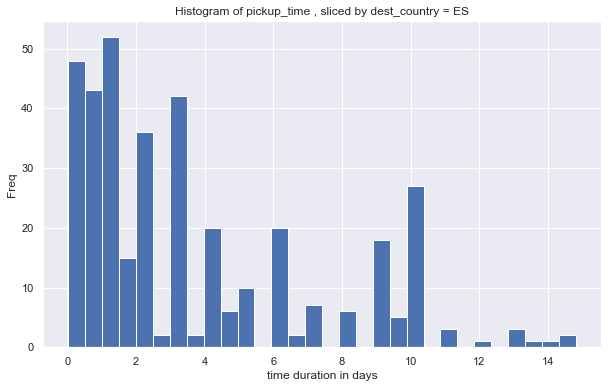

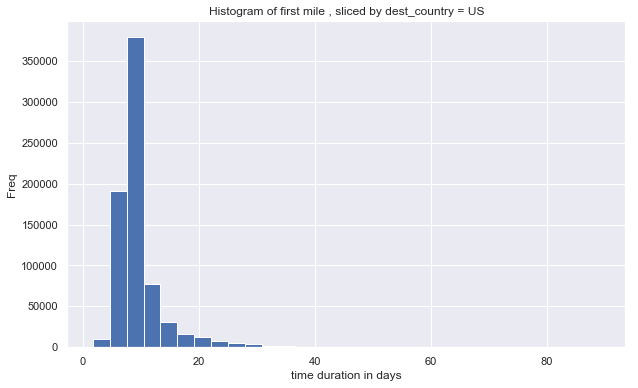

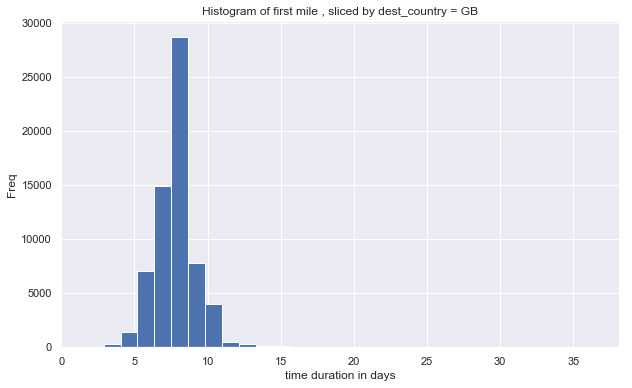

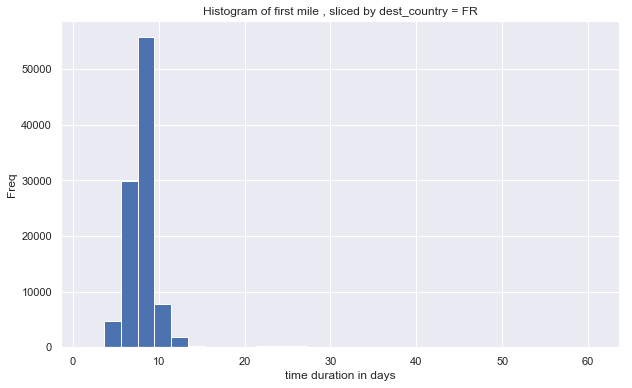

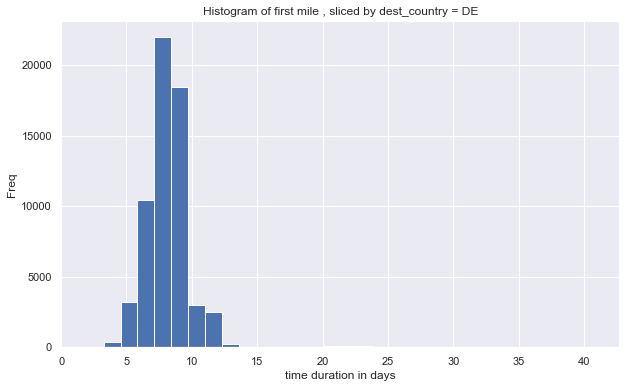

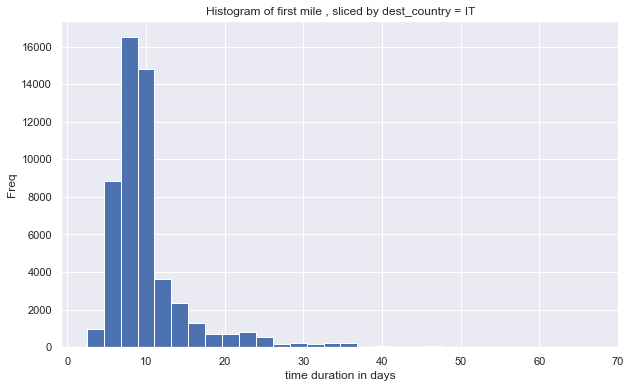

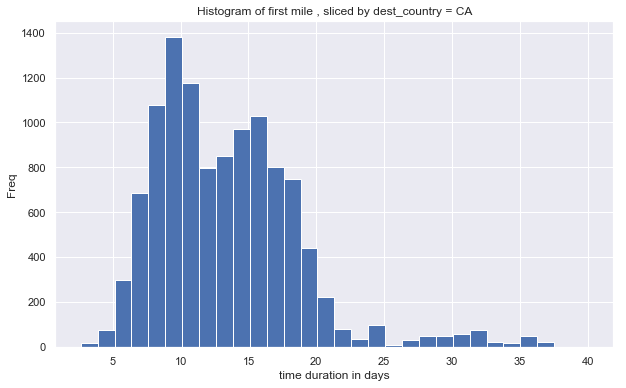

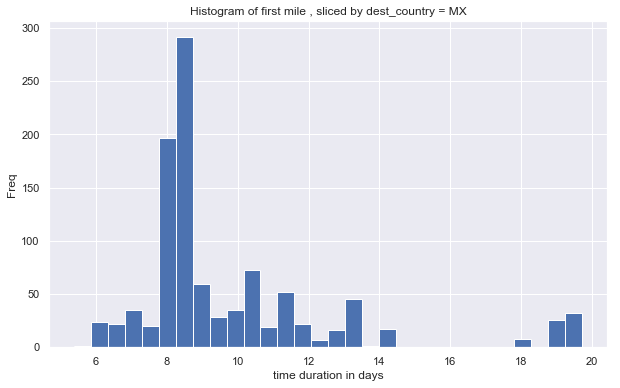

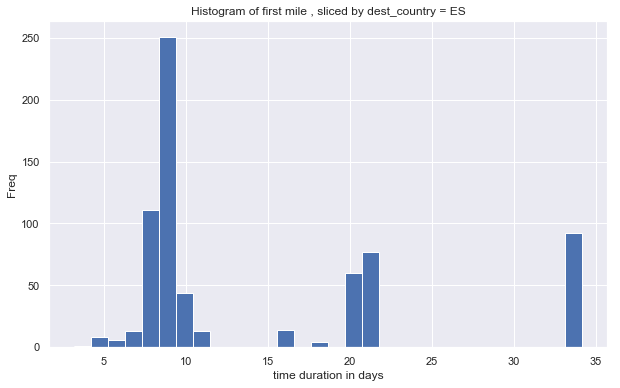

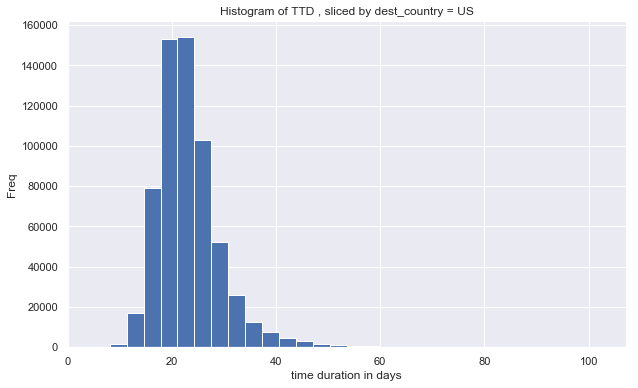

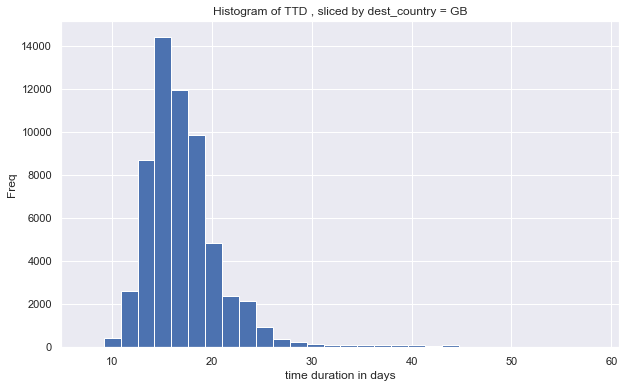

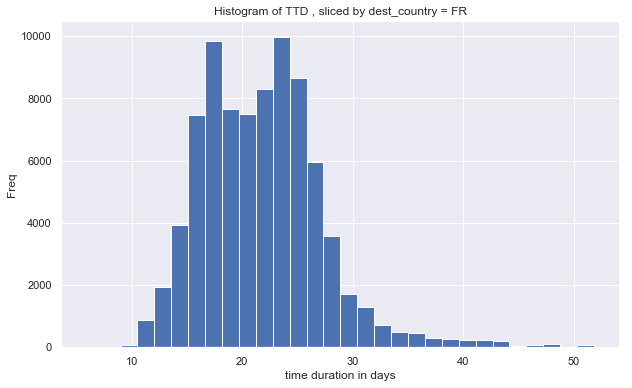

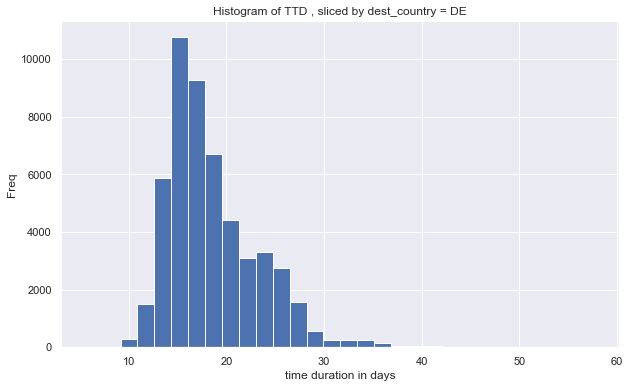

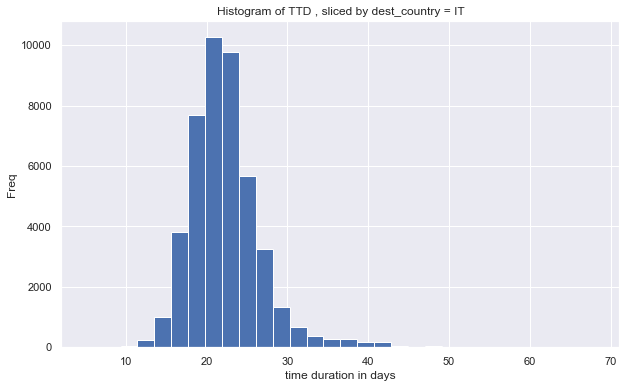

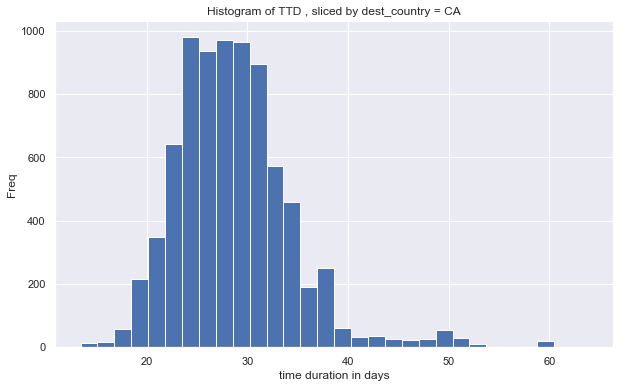

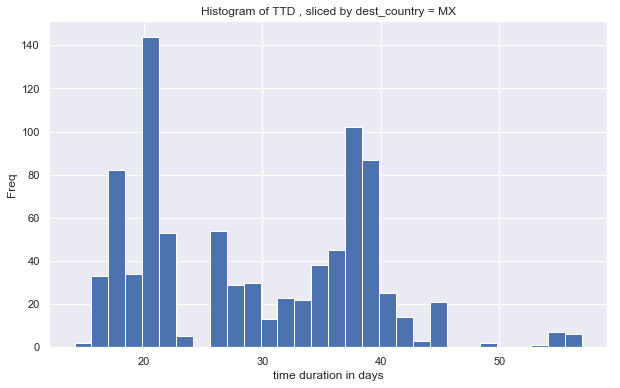

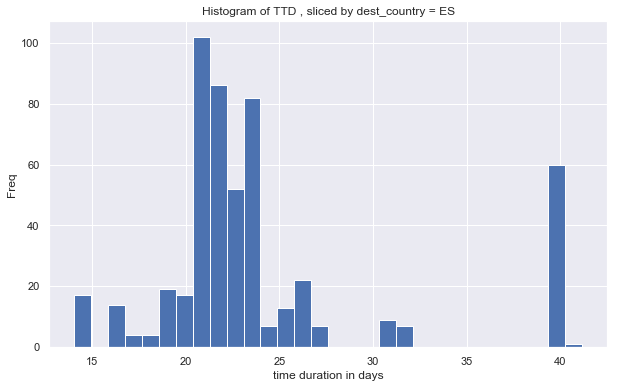

In [180]:
#groups = fusion_raw.groupby('dest_country')
group_list = fusion_raw.dest_country.unique()
time_list = ['order_ship','ship_to_wh','wh_operation','lm_delivery','scan_time','pickup_time','first mile','TTD']

for time in time_list:
    for group_name in group_list:
        plt.xlabel('time duration in days')
        plt.ylabel('Freq')
        plt.title('Histogram of %s , sliced by dest_country = %s' %(time,group_name))
        fusion_raw.loc[fusion_raw.dest_country==group_name,time].hist(figsize=(10,6),bins=30)
        plt.show()

In [90]:
list(groups.groups.keys())

['CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'MX', 'US']